## Part II: Predicting Hall of Fame Careers

In [Part I](https://www.datacamp.com/community/tutorials/scikit-learn-tutorial-baseball-1#gs.T8pYUlE) of this tutorial the focus was determining the number of games that a Major-League Baseball (MLB) team won that season, based on the team’s statistics and other variables from that season.

In the second part of this project, you’ll test out a logistic regression model and a random forest model from `sklearn` to predict which players will be voted into the Hall of Fame, based on the player's career statistics and awards.  Each row will consist of a single player and data related to their career.  There are four main position subgroups in baseball; Infielders, Outfielders, Pitchers, and Catchers.  The focus of this project will be on Infielders and Outfielders.

The National Baseball Hall of Fame and Museum is located in Cooperstown, New York and was dedicated in 1939. A baseball player can be elected to the Hall of Fame if they meet the following criteria:

* The player must have competed at least ten seasons;
* The player has been retired for at least five seasons;
* A screening committee must approve the player’s worthiness to be included on the ballot and most players who played regularly for ten or more years are deemed worthy;
* The player must not be on the ineligible list (that means that the player should not be banned from baseball);
* A player is considered elected if he receives at least 75% of the vote in the election; and
* A player stays on the ballot the following year if they receive at least 5% of the vote and can appear on ballots for a maximum of 10 years.

A player who does not get elected to the Hall of Fame can be added by the Veterans Committee or a Special Committee appointed by the Commissioner of Major League Baseball, but this project will focus only on players who were voted into the Hall of Fame. Fundamentally, what you want to know is: "Can you build a machine learning model that can accurately predict if an MLB baseball player will be voted into the Hall of Fame?".

In the first part of this project, you loaded the data from an SQLite database.  This time, you'll load the data using CSV files. Sean Lahman compiled this data on his [website]( http://www.seanlahman.com/baseball-archive/statistics/).


### Importing Data

You will read in the data from the following CSV files into `pandas` DataFrames:

* Master - Player names, DOB, and biographical info
* Fielding – Fielding statistics
* Batting - Batting statistics
* AwardsPlayers - Awards won by players
* AllstarFull - All-Star appearances
* HallOfFame - Hall of Fame voting data
* Appearances - Details on the positions a player appeared at

First, download the CSV files by [clicking here](http://seanlahman.com/files/database/baseballdatabank-2017.1.zip).  Load `pandas` and rename to `pd`, then read in each of the CSV files to a database.  You’ll only include certain columns, and you can review the available columns [here](http://seanlahman.com/files/database/readme2016.txt).


In [99]:
# Import data to DataFrames
import pandas as pd

master_df = pd.read_csv('Master.csv', usecols=['playerID','nameFirst','nameLast','bats','throws','debut','finalGame'])
fielding_df = pd.read_csv('Fielding.csv', usecols=['playerID','yearID','stint','teamID','lgID','POS','G','GS','InnOuts','PO','A','E','DP'])
batting_df = pd.read_csv('Batting.csv')
awards_df = pd.read_csv('AwardsPlayers.csv', usecols=['playerID','awardID','yearID'])
allstar_df = pd.read_csv('AllstarFull.csv', usecols=['playerID','yearID'])
hof_df = pd.read_csv('HallOfFame.csv', usecols=['playerID','yearid','votedBy','needed_note','inducted','category'])
appearances_df = pd.read_csv('Appearances.csv')

### Data Cleaning and Preprocessing

#### `batting_df`
First, you’ll be working on the `batting_df` DataFrame. Print out the first few rows with the help of the `head()` function:


In [100]:
# Print first few rows of `batting_df`
print(batting_df.head())

    playerID  yearID  stint teamID lgID   G   AB   R   H  2B  ...    RBI   SB  \
0  abercda01    1871      1    TRO  NaN   1    4   0   0   0  ...    0.0  0.0   
1   addybo01    1871      1    RC1  NaN  25  118  30  32   6  ...   13.0  8.0   
2  allisar01    1871      1    CL1  NaN  29  137  28  40   4  ...   19.0  3.0   
3  allisdo01    1871      1    WS3  NaN  27  133  28  44  10  ...   27.0  1.0   
4  ansonca01    1871      1    RC1  NaN  25  120  29  39  11  ...   16.0  6.0   

    CS  BB   SO  IBB  HBP  SH  SF  GIDP  
0  0.0   0  0.0  NaN  NaN NaN NaN   NaN  
1  1.0   4  0.0  NaN  NaN NaN NaN   NaN  
2  1.0   2  5.0  NaN  NaN NaN NaN   NaN  
3  1.0   0  2.0  NaN  NaN NaN NaN   NaN  
4  2.0   2  1.0  NaN  NaN NaN NaN   NaN  

[5 rows x 22 columns]


Making sure your data is tidy is very important; You can read a detailed explanation of tidy data [here]( https://www.jstatsoft.org/index.php/jss/article/view/v059i10/v59i10.pdf).  In short, you need to get to a point where each row is an observation, in this case a player's career, and each column is a variable. Most of the rows in the current DataFrames are from individual seasons.  Each of these seasons need to be compiled into one row for the player's career.  To do this, you'll be creating dictionaries for each player within a dictionary.  Each player's stats will be aggregated to their dictionary, and then the main dictionary can be converted to a DataFrame.

To start, create a dictionary for player's stats and one for years played.  Aggregate each player's statistics from `batting_df` into `player_stats` and data on which years they played into `years_played`:

In [101]:
# Create dictionaries for player stats and years played from `batting_df`

player_stats = {}
years_played = {}
for i, row in batting_df.iterrows():
    playerID = row['playerID']
    if playerID in player_stats:
        player_stats[playerID]['G'] = player_stats[playerID]['G'] + row['G']
        player_stats[playerID]['AB'] = player_stats[playerID]['AB'] + row['AB']
        player_stats[playerID]['R'] = player_stats[playerID]['R'] + row['R']
        player_stats[playerID]['H'] = player_stats[playerID]['H'] + row['H']
        player_stats[playerID]['2B'] = player_stats[playerID]['2B'] + row['2B']
        player_stats[playerID]['3B'] = player_stats[playerID]['3B'] + row['3B']
        player_stats[playerID]['HR'] = player_stats[playerID]['HR'] + row['HR']
        player_stats[playerID]['RBI'] = player_stats[playerID]['RBI'] + row['RBI']
        player_stats[playerID]['SB'] = player_stats[playerID]['SB'] + row['SB']
        player_stats[playerID]['BB'] = player_stats[playerID]['BB'] + row['BB']
        player_stats[playerID]['SO'] = player_stats[playerID]['SO'] + row['SO']
        player_stats[playerID]['IBB'] = player_stats[playerID]['IBB'] + row['IBB']
        player_stats[playerID]['HBP'] = player_stats[playerID]['HBP'] + row['HBP']
        player_stats[playerID]['SH'] = player_stats[playerID]['SH'] + row['SH']
        player_stats[playerID]['SF'] = player_stats[playerID]['SF'] + row['SF']
        years_played[playerID].append(row['yearID'])        
    else:
        player_stats[playerID] = {}
        player_stats[playerID]['G'] = row['G']
        player_stats[playerID]['AB'] = row['AB']
        player_stats[playerID]['R'] = row['R']
        player_stats[playerID]['H'] = row['H']
        player_stats[playerID]['2B'] = row['2B']
        player_stats[playerID]['3B'] = row['3B']
        player_stats[playerID]['HR'] = row['HR']
        player_stats[playerID]['RBI'] = row['RBI']
        player_stats[playerID]['SB'] = row['SB']
        player_stats[playerID]['BB'] = row['BB']
        player_stats[playerID]['SO'] = row['SO']
        player_stats[playerID]['IBB'] = row['IBB']
        player_stats[playerID]['HBP'] = row['HBP']
        player_stats[playerID]['SH'] = row['SH']
        player_stats[playerID]['SF'] = row['SF']
        years_played[playerID] = []
        years_played[playerID].append(row['yearID'])

Now, iterate through the `years_played` dictionary and add the number of years played by each player into the `player_stats` dictionary.

In [102]:
# Iterate through `years_played` and add the number of years played to `player_stats`

for k, v in years_played.items():
    player_stats[k]['Years_Played'] = len(list(set(v)))

Next, aggregate the statistics from `fielding_df` into the `player_stats` dictionary. You’ll be adding new keys to each player’s dictionary within the `player_stats` dictionary as you iterate through `fielding_df`. Create a `fielder_list` to identify which players have had their fielding keys entered so the stats can be added properly.

In [103]:
# Add fielding stats to `player_stats` from `fielding_df`
fielder_list = []
for i, row in fielding_df.iterrows():
    playerID = row['playerID']
    Gf = row['G']
    GSf = row['GS']
    POf = row['PO']
    Af = row['A']
    Ef = row['E']
    DPf = row['DP']
    if playerID in player_stats and playerID in fielder_list:
        player_stats[playerID]['Gf'] = player_stats[playerID]['Gf'] + Gf
        player_stats[playerID]['GSf'] = player_stats[playerID]['GSf'] + GSf
        player_stats[playerID]['POf'] = player_stats[playerID]['POf'] + POf
        player_stats[playerID]['Af'] = player_stats[playerID]['Af'] + Af
        player_stats[playerID]['Ef'] = player_stats[playerID]['Ef'] + Ef
        player_stats[playerID]['DPf'] = player_stats[playerID]['DPf'] + DPf
    else:
        fielder_list.append(playerID)
        player_stats[playerID]['Gf'] = Gf
        player_stats[playerID]['GSf'] = GSf
        player_stats[playerID]['POf'] = POf
        player_stats[playerID]['Af'] = Af
        player_stats[playerID]['Ef'] = Ef
        player_stats[playerID]['DPf'] = DPf


#### `awards_df`
Next up is the `awards_df` DataFrame: throughout a player's career, there are many different awards they may receive for excellent achievement. Print out the unique awards within `awards_df` using the `unique()` method.

In [104]:
# Print out unique awards from `awards_df`
print(awards_df['awardID'].unique())

['Pitching Triple Crown' 'Triple Crown' 'Baseball Magazine All-Star'
 'Most Valuable Player' 'TSN All-Star' 'TSN Guide MVP'
 'TSN Major League Player of the Year' 'TSN Pitcher of the Year'
 'TSN Player of the Year' 'Rookie of the Year' 'Babe Ruth Award'
 'Lou Gehrig Memorial Award' 'World Series MVP' 'Cy Young Award'
 'Gold Glove' 'TSN Fireman of the Year' 'All-Star Game MVP' 'Hutch Award'
 'Roberto Clemente Award' 'Rolaids Relief Man Award' 'NLCS MVP' 'ALCS MVP'
 'Silver Slugger' 'Branch Rickey Award' 'Hank Aaron Award'
 'TSN Reliever of the Year' 'Comeback Player of the Year'
 'Outstanding DH Award' 'Reliever of the Year Award']


As you can see, there are quite a few options in `awards_df`... Do you know all these awards? 

As mentioned in Part I of this tutorial, knowledge of the data you're working with is very important. For example, the best awards to include are the Most Valuable Player, Rookie of the Year, Gold Glove, Silver Slugger, and World Series MVP awards and I determined that entirely based on my experience following MLB Baseball.  It obviously could be determined which of these awards is most correlated with being voted into the Hall of Fame, but that would require much more coding.

Now you need to add a count for each award into each player's dictionary within the `player_stats` dictionary:  first, filter the `awards_df` for each of the awards listed above, creating five new series.  Then create a list called `awards_list` and include each of the five series in the list. As you did above with `fielding_df`, create a list to identify which keys have been added to the dictionaries within `player_stats` for each of the five awards series.  Now create a list called `lists` and include each of the five lists.  You're now ready to loop through `awards_list`, and iterate through each of the awards series counting how many of each award each player has:

In [105]:
# Create DataFrames for each award and include each DataFrame in `awards_list`
mvp = awards_df[awards_df['awardID'] == 'Most Valuable Player']
roy = awards_df[awards_df['awardID'] == 'Rookie of the Year']
gg = awards_df[awards_df['awardID'] == 'Gold Glove']
ss = awards_df[awards_df['awardID'] == 'Silver Slugger']
ws_mvp = awards_df[awards_df['awardID'] == 'World Series MVP']
awards_list = [mvp,roy,gg,ss,ws_mvp]

# Lists for each of the above DataFrames, and include each list in another list
mvp_list = []
roy_list = []
gg_list = []
ss_list = []
ws_mvp_list = []
lists = [mvp_list,roy_list,gg_list,ss_list,ws_mvp_list]

# Add a count for each award for each player in `player_stats`
for index, v in enumerate(awards_list):
    for i, row in v.iterrows():
        playerID = row['playerID']
        award = row['awardID']
        if playerID in player_stats and playerID in lists[index]:
            player_stats[playerID][award] += 1
        else:
            lists[index].append(playerID)
            player_stats[playerID][award] = 1

#### `allstar_df`
The `allstar_df` DataFrame contains information on which players made appearances in Allstar games.  The Allstar game is an exhibition game played each year at mid-season.  Major League Baseball consists of two leagues: the American league and the National league. The top 25 players from each league are selected to represent their league in the Allstar game.

As you did previously, iterate through `allstar_df` and add a count of Allstar game appearances to each dictionary within `player_stats`.

In [106]:
# Add a count for each Allstar game appearance for each player in `player_stats`
allstar_list = []
for i, row in allstar_df.iterrows():
    playerID = row['playerID']
    if playerID in player_stats and playerID in allstar_list:
        player_stats[playerID]['AS_games'] += 1
    else:
        allstar_list.append(playerID)
        player_stats[playerID]['AS_games'] = 1

#### `hof_df`
Next up is the `hof_df` DataFrame, which contains information on which players, managers, and executives have been nominated or inducted into the Hall of Fame, and by what method.  

First, filter `hof_df` to include only players who were inducted into the Hall of Fame. Then iterate through `hof_df` indicating which players in `player_stats` have been inducted into the Hall of Fame as well as how they were inducted:

In [107]:
# filter `hof_df` to include only instances where a player was inducted into the Hall of Fame
hof_df = hof_df[(hof_df['inducted'] == 'Y') & (hof_df['category'] == 'Player')]

# Indicate which players in `player_stats` were inducted into the Hall of Fame
for i, row in hof_df.iterrows():
    playerID = row['playerID']
    if playerID in player_stats:
        player_stats[playerID]['HoF'] = 1
        player_stats[playerID]['votedBy'] = row['votedBy']

You’ve now compiled data from `batting_df`, `fielding_df`, `awards_df`, `allstar_df`, and `hof_df` into the `player_stats` dictionary.  You have a bit more work to do with the `appearances_df` DataFrame, but now is a good time to convert the `player_stats` dictionary into a DataFrame.

Use the `pandas` `from_dict()` method to convert the dictionary to a DataFrame called `stats_df`. The `stats_df` DataFrame is using each player’s unique player ID as the index.  Add a column to `stats_df` called `playerID` derived from the index. Then join `stats_df` with `master_df` using an inner join.
<!-- Do you feel that we should include more information on why we use an inner join here? ---> 

In [108]:
# Convert `player_stats` into a DataFrame
stats_df = pd.DataFrame.from_dict(player_stats, orient='index')

# Add a column for playerID from the `stats_df` index
stats_df['playerID'] = stats_df.index

# Join `stats_df` and `master_df`
master_df = master_df.join(stats_df,on='playerID',how='inner', rsuffix='mstr')

#### `appearances_df`
The last DataFrame is `appearances_df` which contains information on how many appearances each player had at each position for each year.  Print out the first few rows using the `head()` method.

In [109]:
print(appearances_df.head())

   yearID teamID lgID   playerID  G_all  GS  G_batting  G_defense  G_p  G_c  \
0    1871    TRO  NaN  abercda01      1 NaN          1          1    0    0   
1    1871    RC1  NaN   addybo01     25 NaN         25         25    0    0   
2    1871    CL1  NaN  allisar01     29 NaN         29         29    0    0   
3    1871    WS3  NaN  allisdo01     27 NaN         27         27    0   27   
4    1871    RC1  NaN  ansonca01     25 NaN         25         25    0    5   

   ...   G_2b  G_3b  G_ss  G_lf  G_cf  G_rf  G_of  G_dh  G_ph  G_pr  
0  ...      0     0     1     0     0     0     0   NaN   NaN   NaN  
1  ...     22     0     3     0     0     0     0   NaN   NaN   NaN  
2  ...      2     0     0     0    29     0    29   NaN   NaN   NaN  
3  ...      0     0     0     0     0     0     0   NaN   NaN   NaN  
4  ...      2    20     0     1     0     0     1   NaN   NaN   NaN  

[5 rows x 21 columns]


There is a lot of information in `appearances_df` that needs to be extracted. You need to aggregate each players number of appearances to find the total number of career appearances at each position. 

As you may recall from Part I of this tutorial, as Major League Baseball progressed, different eras emerged where the amount of runs per game increased or decreased significantly. This means that when a player played has a large influence on that player's career statistics. The HoF voters take this into account when voting players in, so your model needs that information too.

Create a dictionary called `pos_dict`. Loop through `appearances_df` and add a dictionary for each player as you did above with the `player_stats` dictionary. Aggregate each player's appearances at each position for each season they played using the position as a key and the appearances count as the value. You'll also need to aggregate the number of games each player played in each era using the era as a key and the games played count as the value.

In [110]:
# Iterate through `appearances_df` and add a count for the number of appearances for each player at each position  
# Also, add a count for the number of games played for each player in each era. 
pos_dict = {}
for i, row in appearances_df.iterrows():
    ID = row['playerID']
    year = row['yearID']
    if ID in pos_dict:
        pos_dict[ID]['G_all'] = pos_dict[ID]['G_all'] + row['G_all']
        pos_dict[ID]['G_p'] = pos_dict[ID]['G_p'] + row['G_p'] 
        pos_dict[ID]['G_c'] = pos_dict[ID]['G_c'] + row['G_c'] 
        pos_dict[ID]['G_1b'] = pos_dict[ID]['G_1b'] + row['G_1b'] 
        pos_dict[ID]['G_2b'] = pos_dict[ID]['G_2b'] + row['G_2b'] 
        pos_dict[ID]['G_3b'] = pos_dict[ID]['G_3b'] + row['G_3b'] 
        pos_dict[ID]['G_ss'] = pos_dict[ID]['G_ss'] + row['G_ss'] 
        pos_dict[ID]['G_lf'] = pos_dict[ID]['G_lf'] + row['G_lf'] 
        pos_dict[ID]['G_cf'] = pos_dict[ID]['G_cf'] + row['G_cf'] 
        pos_dict[ID]['G_rf'] = pos_dict[ID]['G_rf'] + row['G_rf'] 
        pos_dict[ID]['G_of'] = pos_dict[ID]['G_of'] + row['G_of'] 
        pos_dict[ID]['G_dh'] = pos_dict[ID]['G_dh'] + row['G_dh']
        if year < 1920:
            pos_dict[ID]['pre1920'] = pos_dict[ID]['pre1920'] + row['G_all']
        elif year >= 1920 and year <= 1941:
            pos_dict[ID]['1920-41'] = pos_dict[ID]['1920-41'] + row['G_all']
        elif year >= 1942 and year <= 1945:
            pos_dict[ID]['1942-45'] = pos_dict[ID]['1942-45'] + row['G_all']
        elif year >= 1946 and year <= 1962:
            pos_dict[ID]['1946-62'] = pos_dict[ID]['1946-62'] + row['G_all']
        elif year >= 1963 and year <= 1976:
            pos_dict[ID]['1963-76'] = pos_dict[ID]['1963-76'] + row['G_all']
        elif year >= 1977 and year <= 1992:
            pos_dict[ID]['1977-92'] = pos_dict[ID]['1977-92'] + row['G_all']
        elif year >= 1993 and year <= 2009:
            pos_dict[ID]['1993-2009'] = pos_dict[ID]['1993-2009'] + row['G_all']     
        elif year > 2009:
            pos_dict[ID]['post2009'] = pos_dict[ID]['post2009'] + row['G_all']  
    else:
        pos_dict[ID] = {}
        pos_dict[ID]['G_all'] = row['G_all']
        pos_dict[ID]['G_p'] = row['G_p'] 
        pos_dict[ID]['G_c'] = row['G_c'] 
        pos_dict[ID]['G_1b'] = row['G_1b'] 
        pos_dict[ID]['G_2b'] = row['G_2b'] 
        pos_dict[ID]['G_3b'] = row['G_3b'] 
        pos_dict[ID]['G_ss'] = row['G_ss'] 
        pos_dict[ID]['G_lf'] = row['G_lf'] 
        pos_dict[ID]['G_cf'] = row['G_cf'] 
        pos_dict[ID]['G_rf'] = row['G_rf'] 
        pos_dict[ID]['G_of'] = row['G_of'] 
        pos_dict[ID]['G_dh'] = row['G_dh']
        pos_dict[ID]['pre1920'] = 0
        pos_dict[ID]['1920-41'] = 0
        pos_dict[ID]['1942-45'] = 0
        pos_dict[ID]['1946-62'] = 0
        pos_dict[ID]['1963-76'] = 0
        pos_dict[ID]['1977-92'] = 0
        pos_dict[ID]['1993-2009'] = 0
        pos_dict[ID]['post2009'] = 0
        if year < 1920:
            pos_dict[ID]['pre1920'] = row['G_all']
        elif year >= 1920 and year <= 1941:
            pos_dict[ID]['1920-41'] = row['G_all']
        elif year >= 1942 and year <= 1945:
            pos_dict[ID]['1942-45'] = row['G_all']
        elif year >= 1946 and year <= 1962:
            pos_dict[ID]['1946-62'] = row['G_all']
        elif year >= 1963 and year <= 1976:
            pos_dict[ID]['1963-76'] = row['G_all']
        elif year >= 1977 and year <= 1992:
            pos_dict[ID]['1977-92'] = row['G_all']
        elif year >= 1993 and year <= 2009:
            pos_dict[ID]['1993-2009'] = row['G_all']     
        elif year > 2009:
            pos_dict[ID]['post2009'] = row['G_all']

Now convert the `pos_dict` dictionary into a DataFrame and print the columns.

In [111]:
# Convert the `pos_dict` to a DataFrame
pos_df = pd.DataFrame.from_dict(pos_dict, orient='index')

# Print the columns
print(pos_df.columns)

Index(['G_3b', 'G_2b', '1942-45', 'G_p', 'G_1b', '1977-92', '1946-62', 'G_cf',
       'G_of', 'G_all', 'G_ss', '1963-76', '1993-2009', 'G_dh', 'G_c', 'G_rf',
       'pre1920', 'post2009', 'G_lf', '1920-41'],
      dtype='object')


Next you want to determine the percentage of times each player played at each position and within each era. Create a list called `pos_col_list` from the columns of `pos_df` and remove the string ‘G_all’. Now create a new column in `pos_df` for the percentage each player played at each position and within each era by looping through `pos_col_list` and dividing the games played at each position or era by the total games played by that player. Print out the first few rows of `pos_df`.

In [112]:
# Create a list from the columns of pos_df and remove the string 'G_all'
pos_col_list = pos_df.columns.tolist()
pos_col_list.remove('G_all')

# Loop through the list and divide each column by the players total games played
for col in pos_col_list:
    column = col + '_percent'
    pos_df[column] = pos_df[col] / pos_df['G_all']
    
print(pos_df.head())

           G_3b  G_2b  1942-45  G_p  G_1b  1977-92  1946-62  G_cf  G_of  \
aardsda01     0     0        0  331     0        0        0     0     0   
aaronha01     7    43        0    0   210        0     1350   308  2760   
aaronto01    10     7        0    0   232        0      141     1   137   
aasedo01      0     0        0  448     0      448        0     0     0   
abadan01      0     0        0    0     8        0        0     0     1   

           G_all       ...         G_ss_percent  1963-76_percent  \
aardsda01    331       ...                  0.0         0.000000   
aaronha01   3298       ...                  0.0         0.590661   
aaronto01    437       ...                  0.0         0.677346   
aasedo01     448       ...                  0.0         0.000000   
abadan01      15       ...                  0.0         0.000000   

           1993-2009_percent  G_dh_percent  G_c_percent  G_rf_percent  \
aardsda01           0.607251      0.000000          0.0      0.0000

As mentioned earlier, this project is focused on infielders and outfielders since each position is judged differently when determining HoF worthiness.  Infielders and outfielders are judged similarly, while pitchers and catchers are judged based on much different playing statistics predominately based on defense.  This is beyond the scope of this project as it would require much more data cleaning and feature engineering.

Since many players played at multiple different positions in the earlier years of MLB, eliminate the pitchers and catchers by filtering out players who played more than 10% of their games at either of those positions.


In [113]:
# Filter `pos_df` to eliminate players who played 10% or more of their games as Pitchers or Catchers
pos_df = pos_df[(pos_df['G_p_percent'] < 0.1) & (pos_df['G_c_percent'] < 0.1)]

Now join `master_df` with `pos_df` using a right join to only keep players who are in `pos_df`:

In [114]:
# Join `pos_df` and `master_df`
master_df = master_df.join(pos_df,on='playerID',how='right')

#### `master_df`
Now filter `master_df` to only include players who were voted into the Hall of Fame or didn’t make it at all.  Some players make it into the Hall by selection from the Veterans Committee, or by a specially appointed committee. These players are typically selected for reasons other than purely their statistics which your model may find difficult to quantify, so it’s best to leave them out of the data set.

In [115]:
# Filter `master_df` to include only players who were voted into the Hall of Fame or Players who did not make it at all
master_df['votedBy'] = master_df['votedBy'].fillna('None')
master_df = master_df[(master_df['votedBy'] == 'None') | (master_df['votedBy'] == 'BBWAA') | (master_df['votedBy'] == 'Run Off')]

The `bats` and `throws` columns need to be converted to numeric. Create a function to convert each `R` to a 1 and each `L` to a `0`. Use the `apply()` method to create numeric columns called `bats_R` and `throws_R`: 

In [116]:
# Create a function to convert the bats and throws colums to numeric
def bats_throws(col):
    if col == "R":
        return 1
    else:
        return 0

# Use the apply method to create numeric columns from the bats and throws columns
master_df['bats_R'] = master_df['bats'].apply(bats_throws)
master_df['throws_R'] = master_df['throws'].apply(bats_throws)

The `debut` and `finalGame` columns are currently strings. You'll need to parse out the years from these columns. First, import `datetime`.  Next, convert the `debut` and `finalGame` columns to a datetime object using `pd.to_datetime()`. Then parse out the year using `dt.strftime(‘%Y’)` and convert to numeric with `pd.to_numberic()`.

In [117]:
# Convert the debut and finalGame columns to datetimes and create new columns for debutYear and finalYear
from datetime import datetime
master_df['debut'] =  pd.to_datetime(master_df['debut'])
master_df['finalGame'] = pd.to_datetime(master_df['finalGame'])
master_df['debutYear'] = pd.to_numeric(master_df['debut'].dt.strftime('%Y'), errors='coerce')
master_df['finalYear'] = pd.to_numeric(master_df['finalGame'].dt.strftime('%Y'), errors='coerce')

There are currently some unnecessary columns in `master_df`.  Use the `drop()` method on `master_df` and create a new DataFrame called `df`.  Now is a good time to print the columns in `df` and display the count of null values for each column.

In [118]:
# Eliminating unnecessary columns
df = master_df.drop(['votedBy', 'IBB', 'bats', 'throws',
'GSf', 'POf','Gf', 'playerIDmstr'], axis=1)

# Print df columns and a list of null values
print(df.columns)
print(df.isnull().sum(axis=0).tolist())

Index(['playerID', 'nameFirst', 'nameLast', 'debut', 'finalGame', 'AB', 'DPf',
       'SB', 'RBI', 'H', 'Years_Played', 'Ef', 'Af', 'SF', '2B', 'HR', 'BB',
       'SH', 'G', '3B', 'SO', 'HBP', 'R', 'AS_games', 'Gold Glove',
       'Silver Slugger', 'Rookie of the Year', 'HoF', 'Most Valuable Player',
       'World Series MVP', 'G_3b', 'G_2b', '1942-45', 'G_p', 'G_1b', '1977-92',
       '1946-62', 'G_cf', 'G_of', 'G_all', 'G_ss', '1963-76', '1993-2009',
       'G_dh', 'G_c', 'G_rf', 'pre1920', 'post2009', 'G_lf', '1920-41',
       'G_3b_percent', 'G_2b_percent', '1942-45_percent', 'G_p_percent',
       'G_1b_percent', '1977-92_percent', '1946-62_percent', 'G_cf_percent',
       'G_of_percent', 'G_ss_percent', '1963-76_percent', '1993-2009_percent',
       'G_dh_percent', 'G_c_percent', 'G_rf_percent', 'pre1920_percent',
       'post2009_percent', 'G_lf_percent', '1920-41_percent', 'bats_R',
       'throws_R', 'debutYear', 'finalYear'],
      dtype='object')
[0, 28, 0, 0, 0, 0, 202, 268,

In Part I of this tutorial, you were dealing with team statistics and the null values were likely due to missing data.  A team is never going to make it through an entire season without a double play, for example.  

With players, it is much more likely that null values are zeros. 

That's why you're going to create a list of the numeric columns and loop through the list, filling the null values with zeros using the `fillna()` method.  Then use the `dropna()` method to eliminate any remaining null values.


In [119]:
# Fill null values in numeric columns with 0
fill_cols = ['AS_games', 'Silver Slugger', 'Rookie of the Year', 'Gold Glove', 'Most Valuable Player', 'HoF',
'1977-92', 'pre1920', '1942-45', '1946-62', '1963-76', '1920-41', '1993-2009', 'HBP', 'SB', 'SF', 'SH', 'RBI', 'SO', 'World Series MVP', 'G_dh_percent', 'G_dh', 'Af', 'DPf', 'Ef']

for col in fill_cols:
    df[col] = df[col].fillna(0)

# Drop any additional rows with null values
df = df.dropna()

# Check to make sure null values have been removed
print(df.isnull().sum(axis=0).tolist())

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


### Feature Engineering: Creating New Features

Now that the data has been cleaned up, you can add new features. The important baseball statistics that are missing from our data are batting average, on-base percentage, slugging percentage, and on-base plus slugging percentage.  

Add each of these statistics by using the following formulas:

* Batting Ave. = At Bats / Hits
* Plate Appearances = At Bats + Walks + Sacrifice Flys & Hits + Hit by Pitch
* On-base % = (Hits + Walks + Hit by Pitch) / Plate Appearances
* Slugging % = ((Home Runs * 4) + (Triples * 3) + (Doubles * 2) + Singles) / At Bats
* On-Base plus Slugging % = On-base % + Slugging %


In [120]:
# Create Batting Average (`AVE`) column
df['AVE'] = df['H'] / df['AB']

# Create On Base Percent (`OBP`) column
plate_appearances = (df['AB'] + df['BB'] + df['SF'] + df['SH'] + df['HBP'])
df['OBP'] = (df['H'] + df['BB'] + df['HBP']) / plate_appearances

# Create Slugging Percent (`Slug_Percent`) column
single = ((df['H'] - df['2B']) - df['3B']) - df['HR']
df['Slug_Percent'] = ((df['HR'] * 4) + (df['3B'] * 3) + (df['2B'] * 2) + single) / df['AB']

# Create On Base plus Slugging Percent (`OPS`) column
hr = df['HR'] * 4
triple = df['3B'] * 3
double = df['2B'] * 2
df['OPS'] = df['OBP'] + df['Slug_Percent']

There are a few anomalies in your data that need to be resolved, which you might know if you have some knowledge on MLB history:

* The first two involve players who had Hall of Fame worthy statistics, but were banned from baseball for life. For example, Shoeless Joe Jackson (`playerID == jacksjo01`) was an incredible player but got caught up in the 1919 Black Sox scandal when multiple players from the Chicago White Sox accepted money from the Mobsters and intentionally lost. Even though he played extremely well in that series, he was banned for life. 


* In addition, you see Pete Rose (`playerID == rosepe01`), the all-time hits leader. Nicknamed Charlie Hussle, he was the everyman and had an incredible career playing for the Cincinnati Reds.  Shortly after he retired as a player he became the Manager of the Reds and got caught betting on baseball games including betting on his own team to win. He was also banned for life. It's best to remove these two players from the dataset.

In [121]:
# Eliminate Jackson and Rose from `df`
df = df[(df['playerID'] != 'rosepe01') & (df['playerID'] != 'jacksjo01')]

* The other anomaly that needs to be resolved is a much different situation than the two above. Jackie Robinson was an all-time great, and played for the Brooklyn Dodgers putting up incredible statistics during the years he played. He also broke the color barrier in Major League Baseball, becoming the first African American Major Leaguer. The problem is, his career started very late at the age of 26 which was completely outside of his control and limited his career statistics.

Out of respect for Jackie Robinson (`playerID == robinja02`) and the incredible impact he had on the game of baseball, instead of removing him, create a function to identify him as the first African American to play in the Major Leagues.


In [122]:
# Make a function that will create a new column to honor Jackie Robinson, the first African American Major league Baseball Player
def first_aap(col):
    if col == 'robinja02':
        return 1
    else:
        return 0
    
df['first_aap'] = df['playerID'].apply(first_aap)

Now it’s time to visualize some of the data to gain a better understanding. Filter `df` to only include Hall of Fame players and print the length.

In [123]:
# Filter the `df` for the remaining Hall of Fame members in the data
df_hof = df[df['HoF'] == 1]

# Print the length of the new DataFrame
print(len(df_hof))

70


You have 70 Hall of Famers left in the data set. Plot out distributions for Hits, Home Runs, Years Played, and All-Star Game Appearances for these Hall of Famers.

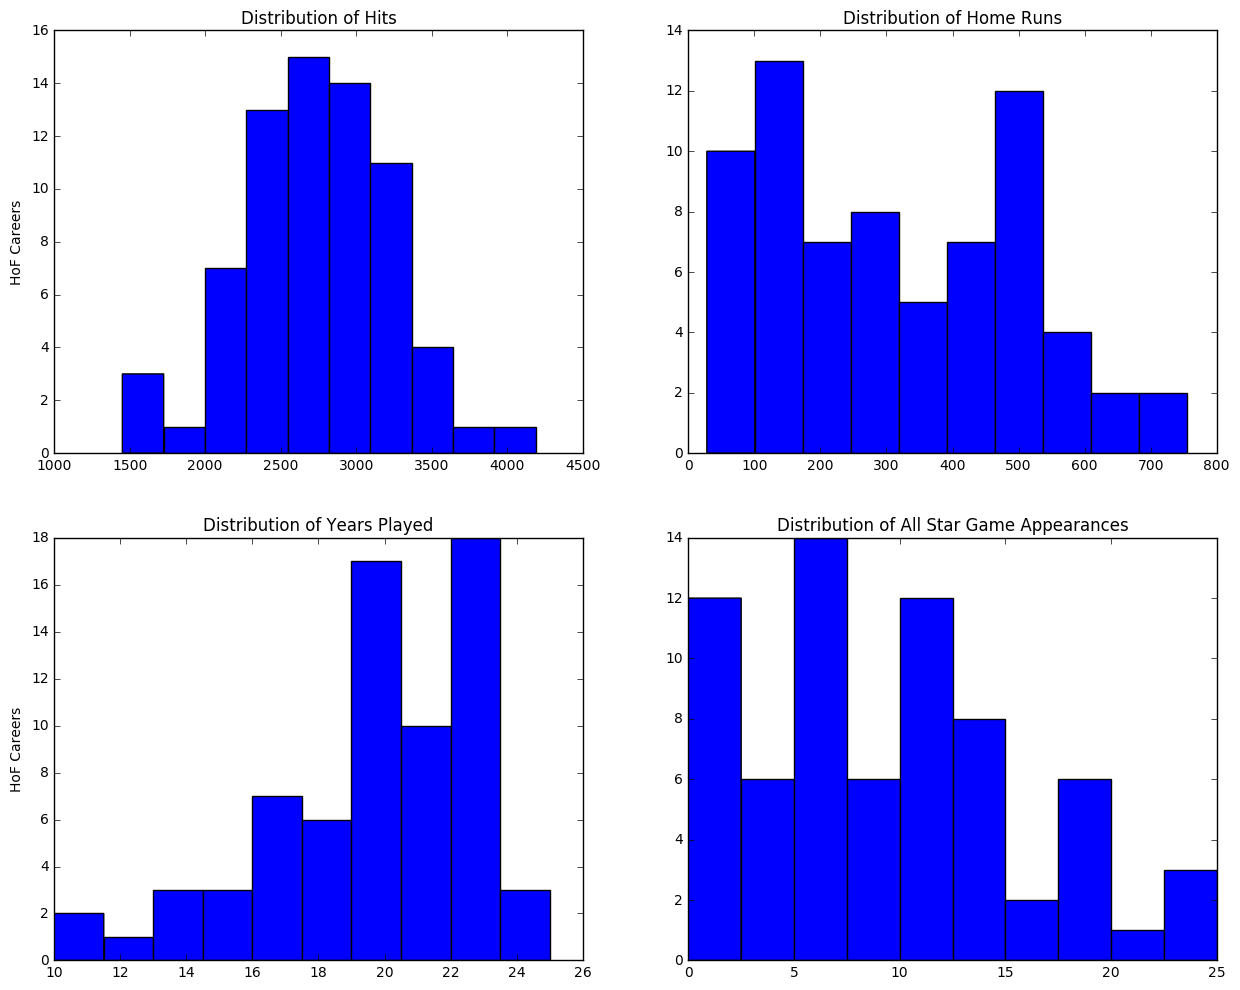

In [124]:
import matplotlib.pyplot as plt
%matplotlib inline

# Create distribution plots for Hits, Home Runs, Years Played and All Star Games
fig = plt.figure(figsize=(15, 12))
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

ax1.hist(df_hof['H'])
ax1.set_title('Distribution of Hits')
ax1.set_ylabel('HoF Careers')
ax2.hist(df_hof['HR'])
ax2.set_title('Distribution of Home Runs')
ax3.hist(df_hof['Years_Played'])
ax3.set_title('Distribution of Years Played')
ax3.set_ylabel('HoF Careers')
ax4.hist(df_hof['AS_games'])
ax4.set_title('Distribution of All Star Game Appearances')

plt.show()

Next, create a scatter plot for Hits vs. Batting Average and one for Home Runs vs. Batting Average. First, filter `df` to only include players who played 10 or more seasons which is the minimum for Hall of Fame eligibility. 

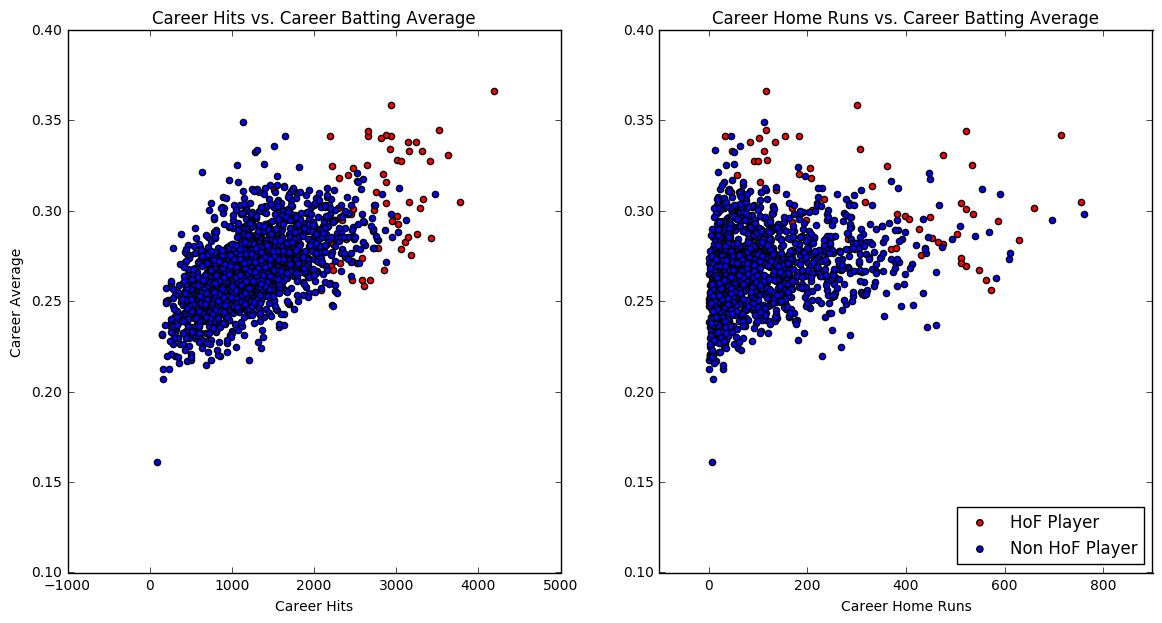

In [125]:
# Filter `df` for players with 10 or more years of experience
df_10 = df[(df['Years_Played'] >= 10) & (df['HoF'] == 0)]
                                         
# Create Scatter plots for Hits vs. Average and Home Runs vs. Average
fig = plt.figure(figsize=(14, 7))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.scatter(df_hof['H'], df_hof['AVE'], c='r', label='HoF Player')
ax1.scatter(df_10['H'], df_10['AVE'], c='b', label='Non HoF Player')
ax1.set_title('Career Hits vs. Career Batting Average')
ax1.set_xlabel('Career Hits')
ax1.set_ylabel('Career Average')
ax2.scatter(df_hof['HR'], df_hof['AVE'], c='r', label='HoF Player')
ax2.scatter(df_10['HR'], df_10['AVE'], c='b', label='Non HoF Player')
ax2.set_title('Career Home Runs vs. Career Batting Average')
ax2.set_xlabel('Career Home Runs')
ax2.legend(loc='lower right', scatterpoints=1)
plt.show()

When you created new features, you may have also created new null values.  Print out the count of null values for each column.

In [126]:
# Check for null values
print(df.isnull().sum(axis=0).tolist())

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 79, 65, 79, 79, 0]


There are not many null values so drop the rows that have null values in them.

In [127]:
# Eliminate rows with null values
df = df.dropna()

In Part I, the data was split into testing and training sets by taking a random slice of the data for each. This time you’ll be using cross-validation to train and test the models. Since a player must wait 5 years to become eligible for the HoF ballot, and can remain on the ballot for as many as 10 years then there are still eligible players who played their final season in the last 15 years. 

Make sure to separate out the players who played their most recent season in the last 15 years so you can use this as “new” data once you have a model that’s trained and tested. 

Add a column to `df` for years since last season (`YSLS`) by subtracting the `finalYear` column from 2016. Next, create a new DataFrame called `df_hitters` by filtering `df` for players whose last season was more than 15 years ago and create one called `df_eligible` for players whose last season was 15 or less years ago.


In [128]:
# Create column for years since retirement
df['YSLS'] = 2016 - df['finalYear']

# Filter `df` for players who retired more than 15 years ago
df_hitters = df[df['YSLS'] > 15]

# Filter `df` for players who retired less than 15 years ago and for currently active players
df_eligible = df[df['YSLS']<= 15]

Now you need to select the columns to include in the model.  First, print out the columns.

In [129]:
print(df.columns)

Index(['playerID', 'nameFirst', 'nameLast', 'debut', 'finalGame', 'AB', 'DPf',
       'SB', 'RBI', 'H', 'Years_Played', 'Ef', 'Af', 'SF', '2B', 'HR', 'BB',
       'SH', 'G', '3B', 'SO', 'HBP', 'R', 'AS_games', 'Gold Glove',
       'Silver Slugger', 'Rookie of the Year', 'HoF', 'Most Valuable Player',
       'World Series MVP', 'G_3b', 'G_2b', '1942-45', 'G_p', 'G_1b', '1977-92',
       '1946-62', 'G_cf', 'G_of', 'G_all', 'G_ss', '1963-76', '1993-2009',
       'G_dh', 'G_c', 'G_rf', 'pre1920', 'post2009', 'G_lf', '1920-41',
       'G_3b_percent', 'G_2b_percent', '1942-45_percent', 'G_p_percent',
       'G_1b_percent', '1977-92_percent', '1946-62_percent', 'G_cf_percent',
       'G_of_percent', 'G_ss_percent', '1963-76_percent', '1993-2009_percent',
       'G_dh_percent', 'G_c_percent', 'G_rf_percent', 'pre1920_percent',
       'post2009_percent', 'G_lf_percent', '1920-41_percent', 'bats_R',
       'throws_R', 'debutYear', 'finalYear', 'AVE', 'OBP', 'Slug_Percent',
       'OPS', 'first_a

Make a list with the columns to include in the model and create a new DataFrame called `data` from `df_hitters` using the list of columns. Include `playerID`, `nameFirst`, and `nameLast` in the list, as you’ll want those columns when you display the results of your predictions with the new data.  You’ll need to drop those three columns for any data used in the model.

In [130]:
# Select columns to use for models, and identification columns
num_cols_hitters = ['playerID', 'nameFirst', 'nameLast', 'HoF', 'Years_Played', 'H', 'BB', 'HR', 'AVE', 'OBP', 'Slug_Percent', 'OPS',  'RBI',
       'R', 'SB', '2B', '3B', 'AB', 'SO', 'Most Valuable Player', 'World Series MVP', 'AS_games','Gold Glove', 'Rookie of the Year', 
       'Silver Slugger', 'bats_R', 'throws_R', 'DPf', 'Af', 'Ef', 'YSLS', 'G_all', 
       '1963-76_percent', '1993-2009_percent', '1946-62_percent', 'G_1b_percent', '1942-45_percent',
       'G_dh_percent', '1920-41_percent', 'G_ss_percent',
       'post2009_percent', '1977-92_percent', 'G_2b_percent', 'G_3b_percent',
       'G_of_percent', 'pre1920_percent', 'first_aap']

# Create a new DataFrame (`data`) from the `df_hitters` using the columns above
data = df_hitters[num_cols_hitters]

Print out how many rows are in `data` and how many of those rows are Hall of Famers.

In [131]:
# Print length of data
print(len(data))

# Print how many Hall of Fame members are in data
print(len(data[data['HoF'] == 1]))

6239
61


There are 6,239 rows and 61 of those are Hall of Famers for your model to identify. Create your `target` Series from the `HoF` column of `data` and your `features` DataFrame by dropping the identification columns and the target column.

In [132]:
# Create `target` Series
target = data['HoF']

# Create `features` DataFrame
features = data.drop(['playerID', 'nameFirst', 'nameLast', 'HoF'], axis=1)

### Selecting Error Metric and Model

As was indicated earlier, the question you're trying to answer is:

***"Can you build a machine learning model that can accurately predict if an MLB baseball player will be voted into the Hall of Fame?"***


The error metric for Part II is simple.  How accurate are your predictions? How many "True Positives" have you predicted where the player was predicted to be in the HoF and they are a HoF member. How many “False Positives” have you predicted where the player was predicted to be in the HoF and they are not a HoF member. Lastly, How many “False Negatives” where the player was predicted to not be in the HoF when the player was actually a HoF member.

#### Logistic Regression

The first model you’ll try is a Logistic Regression model. You’ll be using the Kfold cross-validation technique and you can learn more [here]( http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold).

Import `cross_val_predict`, and `KFold` from `sklearn.cross_validation` and `LogisticRegression` from `sklearn.linear_model`. Create a logistic regression model `lr` and be sure to set the `class_weight` perimeter to ‘balanced’ because there are significantly more non-HoF members in the data. 
Create an instance of the KFold class (`kf`) and finally, make predictions (`predictions_lr`) with `cross_val_predict()` using your model `lr`, features, target, and setting the `cv` parameter to `kf`.


In [133]:
# Import cross_val_predict, KFold and LogisticRegression from 'sklearn'
from sklearn.cross_validation import cross_val_predict, KFold
from sklearn.linear_model import LogisticRegression

# Create Logistic Regression model
lr = LogisticRegression(class_weight='balanced')

# Create an instance of the KFold class
kf = KFold(features.shape[0], random_state=1)

# Create predictions using cross validation
predictions_lr = cross_val_predict(lr, features, target, cv=kf)

To determine accuracy, you need to compare your predictions to the target. Import `numpy` as `np` and convert `predictions_lr` and `target` to NumPy arrays. 

In [134]:
# Import NumPy
import numpy as np

# Convert predictions and target to NumPy arrays
np_predictions_lr = np.asarray(predictions_lr)
np_target = target.as_matrix()

Create a filter for each of the four possible prediction scenarios:

* True Positive: Predictions = 1, Target = 1
* Fales Negative: Predictions = 0, Target = 1
* False Positive: Predictions = 1, Target = 0
* True Negative: Predictions = 0, Target = 0

Then determine the count by applying the filter to your predictions. Now you can determine your accuracy rate using the following formulas:

* True Positive rate: True Positives / (True Positives + False Negatives)
* False Negative rate: False Negatives / (False Negatives + True Positives)
* False Positive rate: False Positives / (False Positives + True Negatives)

Print out the count for each except True Negatives and each of your accuracy rates. 


In [135]:
# Determine True Positive count
tp_filter_lr = (np_predictions_lr == 1) & (np_target == 1)
tp_lr = len(np_predictions_lr[tp_filter_lr])

# Determine False Negative count
fn_filter_lr = (np_predictions_lr == 0) & (np_target == 1)
fn_lr = len(np_predictions_lr[fn_filter_lr])

# Determine False Positive count
fp_filter_lr = (np_predictions_lr == 1) & (np_target == 0)
fp_lr = len(np_predictions_lr[fp_filter_lr])

# Determine True Negative count
tn_filter_lr = (np_predictions_lr == 0) & (np_target == 0)
tn_lr = len(np_predictions_lr[tn_filter_lr])

# Determine True Positive rate
tpr_lr = tp_lr / (tp_lr + fn_lr)

# Determine False Negative rate
fnr_lr = fn_lr / (fn_lr + tp_lr)

# Determine False Positive rate
fpr_lr = fp_lr / (fp_lr + tn_lr)

# Print each count
print(tp_lr)
print(fn_lr)
print(fp_lr)

# Print each rate
print(tpr_lr)
print(fnr_lr)
print(fpr_lr)

54
7
36
0.8852459016393442
0.11475409836065574
0.005827128520556815


That first model was fairly accurate, selecting 54 of 61 Hall of Famers, but it had a relatively high false negative count at 36. 

#### Random Forest 

Next up is a Random Forest model. Import `RandomForestClassifier` from `sklearn.ensemble`. For this model, instead of setting `class_weight` to balanced, you’ll set it to `penalty` which is a dictionary you need to create with key 0 set to 100 and key 1 set to 1.

Create your model `rf` and set the parameters as follows: `random_state`=1, `n_estimators`=12, `max_depth` = 11, `min_samples_leaf` = 1, and `class_weight` = `penalty`.

Finally, make your predictions (`predictions_rf`) using `cross_val_predict()` the same as the previous model and again, convert your predictions to a NumPy array.


In [136]:
# Import RandomForestClassifier from sklearn
from sklearn.ensemble import RandomForestClassifier

# Create penalty dictionary
penalty = {
    0: 100,
    1: 1
}

# Create Random Forest model
rf = RandomForestClassifier(random_state=1,n_estimators=12, max_depth=11, min_samples_leaf=1, class_weight=penalty)

# Create predictions using cross validation
predictions_rf = cross_val_predict(rf, features, target, cv=kf)

# Convert predictions to NumPy array
np_predictions_rf = np.asarray(predictions_rf)

As you did with the previous model, determine your True Positive, False Negative, and False Positive counts and rates.

In [137]:
# Determine True Positive count
tp_filter_rf = (np_predictions_rf == 1) & (np_target == 1)
tp_rf = len(np_predictions_rf[tp_filter_rf])

# Determine False Negative count
fn_filter_rf = (np_predictions_rf == 0) & (np_target == 1)
fn_rf = len(np_predictions_rf[fn_filter_rf])

# Determine False Positive count
fp_filter_rf = (np_predictions_rf == 1) & (np_target == 0)
fp_rf = len(np_predictions_rf[fp_filter_rf])

# Determine True Negative count
tn_filter_rf = (np_predictions_rf == 0) & (np_target == 0)
tn_rf = len(np_predictions_rf[tn_filter_rf])


# Determine True Positive rate
tpr_rf = tp_rf / (tp_rf + fn_rf)

# Determine False Negative rate
fnr_rf = fn_rf / (fn_rf + tp_rf)

# Determine False Positive rate
fpr_rf = fp_rf / (fp_rf + tn_rf)

# Print each count
print(tp_rf)
print(fn_rf)
print(fp_rf)

# Print each rate
print(tpr_rf)
print(fnr_rf)
print(fpr_rf)

50
11
2
0.819672131147541
0.18032786885245902
0.0003237293622531564


The Random Forest model was slightly less accurate predicting 50 of 61 Hall of Famers, but with a very low false negative count of only 2.

The Random Forest model seems to perform better overall, so that’s the one you’ll use to make predictions with the “new data” you set aside.

Create a new DataFrame (`new_data`) from `df_eligible` using the `num_cols_hitters` list. Now create another DataFrame (`new_features`) by dropping the identification columns and the target column.


In [138]:
# Create a new DataFrame from `df_eligable` using `num_col_hitters`
new_data = df_eligible[num_cols_hitters]

# Create a new features DataFrame
new_features = new_data.drop(['playerID', 'nameFirst', 'nameLast', 'HoF'], axis=1)

Now you can use the `fit()` method to fit the `rf` model using the `features` and `target` you used earlier. Next, you can predict the probability that a player in the “new data” will be voted into the Hall of Fame. Use the `predict_proba()` method on the `rf` model using `new_features`.

In [139]:
# Fit the Random Forest model
rf.fit(features, target)

# Estimate probabilities of Hall of Fame induction
probabilities = rf.predict_proba(new_features)

Finally, convert `probabilities` to a `pandas` DataFrame called `hof_predictions`.  Sort `hof_predictions` in descending order.

Now, print out each of the first 50 rows from `hof_predictions` along with the names and important statistics found in `new_data`.  These are the 50 players your model has predicted to be the most likely to be voted into the Hall of Fame, along with the estimated probability and the players career statistics.


In [140]:
# Convert predictions to a pandas DataFrame and sort descending
hof_predictions = pd.DataFrame(probabilities[:,1])
hof_predictions = hof_predictions.sort_values(0,ascending=False)
hof_predictions['Probability'] = hof_predictions[0]

# Print 50 highest probability HoF inductee's from still eligible players
for i, row in hof_predictions.head(50).iterrows():
    prob = ' '.join(('HoF Probability =' , str(row['Probability'])))
    print('')
    print(prob)
    print(new_data.iloc[i,1:27])


HoF Probability = 1.0
nameFirst                 Adrian
nameLast                  Beltre
HoF                            0
Years_Played                  19
H                           2942
BB                           775
HR                           445
AVE                      0.28577
OBP                     0.337833
Slug_Percent            0.479845
OPS                     0.817678
RBI                         1571
R                           1428
SB                           119
2B                           591
3B                            36
AB                         10295
SO                          1584
Most Valuable Player           0
World Series MVP               0
AS_games                       4
Gold Glove                     5
Rookie of the Year             0
Silver Slugger                 4
bats_R                         1
throws_R                       1
Name: 1123, dtype: object

HoF Probability = 1.0
nameFirst                  Manny
nameLast                 Ramirez
HoF 

As it stands, the model appears to do a really good job of making predictions, with a few exceptions. Harold Baines, for example, was a solid player and has a legitimate argument for making the HoF, but the model predicts he has a 100% chance of making it and that is not accurate. Additionally, the model is not accounting for players who were caught or accused of steroid use, which may prevent them from being elected to the HoF.

This concludes the second part of our tutorial series on Scikit-Learn and sports analytics. You imported the data from CSV files, cleaned and aggregated it.  You generated new features in the data and got a better understanding by visualizing it. You learned how to create a Logistic Regression model and a Random Forest model. You also learned how to use K-Fold Cross Validation to train and test your model, how to check the accuracy of your classification models, and you made predictions using new data.

If you enjoyed this project, try to build your own model for predicting which Pitchers will be voted into the Hall of Fame.  Good Luck!
